In [1]:
import re
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from gensim.utils import tokenize
import LRDEstimator
import utils
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
import scikit_posthocs as sp

## Standardized Project Gutenberg Corpus

### Prepare the data

In [7]:
# Read sampled dataset
spgc_metadata_sampled = pd.read_csv("data/spgc_metadata_sampled.csv")

In [8]:
# We will be calculating Coco for pooled embeddings of order 1, 3, 9 and 27
# Then we will be fitting power law (gamma) and stretched exponential function (delta and beta)
# To our dataframe we need to add columns for storing the results
new_columns = [
    "gamma_1", "gamma_3", "gamma_9", "gamma_27",
    "delta_1", "delta_3", "delta_9", "delta_27",
    "beta_1", "beta_3", "beta_9", "beta_27",
]
spgc_metadata_sampled[new_columns] = np.nan

### Define reusable functions

In [9]:
def load_word2vec_embeddings(language_code: str, base_path: str = "embeddings") -> KeyedVectors:
    """
    Load word2vec embeddings for a given language code.
    """
    model_path = f"{base_path}/word2vec_{language_code}.bin"
    return KeyedVectors.load_word2vec_format(model_path, binary=True)

In [10]:
def load_tokens(file_name: str, base_path: str = "data/SGPC") -> list:
    """
    Load tokens from a file and return them as a list.
    """
    file_path = f"{base_path}/{file_name}_tokens.txt"
    with open(file_path, mode="r", encoding="UTF-8") as f:
        tokens = f.read().split("\n")
    return tokens


In [11]:
def compute_coco_values_for_book(vectors: np.ndarray, 
                                 file_name: str,
                                 language: str,
                                 pool_order: int,
                                 coco_results: list,
                                 lag_growth_factor: float = 1.1):
    """
    Given the vectors for a single book, compute CoCo values at various lags
    and store them in the coco_results list of dicts.
    """
    lrd = LRDEstimator.LRDEstimator(vectors)
    max_lag = int(vectors.shape[0] / 2) # TBD: maybe this should be smaller for poolend embeddings?
    current_lag = 1
    
    while current_lag < max_lag:
        # Example without permutation test:
        coco_value = lrd.calculate_coco(lag=current_lag, pool_order=pool_order)
        
        coco_results.append({
            "language": language,
            "book_id": file_name,
            "pool_order": pool_order,
            "lag": int(current_lag),
            "coco_value": coco_value,
        })
        
        # Increase lag by ~10%
        current_lag = int(np.ceil(current_lag * lag_growth_factor))

In [12]:
def fit_and_store_curves(spgc_df, coco_results, file_name, pool_order):
    """
    Fit power law and stretched exponential to the CoCo results for a single
    book_id and pool_order. Store results back into spgc_df.
    """
    # Filter the relevant CoCo results
    book_data = [
        r for r in coco_results 
        if (r["book_id"] == file_name) and (r["pool_order"] == pool_order)
    ]
    if not book_data:
        return  # No data to fit
    
    lags = np.array([d["lag"] for d in book_data])
    c_coco = np.array([d["coco_value"] for d in book_data])
    abs_coco = np.abs(c_coco)
    
    # Fit power law
    try:
        popt_pl, _ = curve_fit(
            utils.power_law,
            lags,
            abs_coco,
            bounds=([-np.inf, -np.inf], [np.inf, 0]),
            maxfev=5000
        )
        gamma_col = f"gamma_{pool_order}"
        spgc_df.loc[spgc_df["id"] == file_name, gamma_col] = popt_pl[1]
    except RuntimeError:
        pass  # If fitting fails, leave as NaN
    
    # Fit stretched exponential
    try:
        popt_se, _ = curve_fit(
            utils.stretched_exponential,
            lags,
            abs_coco,
            bounds=([0, 0, -np.inf], [np.inf, 1, np.inf]),
            maxfev=5000
        )
        delta_col = f"delta_{pool_order}"
        beta_col = f"beta_{pool_order}"
        spgc_df.loc[spgc_df["id"] == file_name, delta_col] = popt_se[0]
        spgc_df.loc[spgc_df["id"] == file_name, beta_col] = popt_se[1]
    except RuntimeError:
        pass  # If fitting fails, leave as NaN

In [13]:
def process_language(spgc_df, language, pool_orders, coco_results):
    """
    Process all books for a single language and multiple pool_orders.
    """
    print(f"Processing language: {language}")
    language_code = re.findall(r"[a-z]{2}", language)[0]
    
    # Filter metadata for the current language
    spgc_metadata_current = spgc_df[spgc_df["language"] == language]
    
    # Load embeddings once per language
    model_current = load_word2vec_embeddings(language_code)
    
    # Iterate through each book in the current language
    for index, row in spgc_metadata_current.iterrows():
        file_name = row["id"]
        
        # Load tokens
        tokens = load_tokens(file_name)
        
        # Build embeddings
        vectors = np.asarray([model_current[w] for w in tokens if w in model_current])
        
        # Skip if not enough vectors
        if len(vectors) < 2:
            continue
        
        # For each pool_order, compute CoCo values
        for p_order in pool_orders:
            compute_coco_values_for_book(
                vectors=vectors,
                file_name=file_name,
                language=language,
                pool_order=p_order,
                coco_results=coco_results
            )
        
        # For each pool_order, fit the curves and store
        for p_order in pool_orders:
            fit_and_store_curves(spgc_df, coco_results, file_name, p_order)

### Run calculations

In [14]:
def main_coco_pipeline(spgc_metadata_sampled):
    """
    Main pipeline function that:
      1) Determines unique languages,
      2) Iterates over each language,
      3) Computes CoCo for each pool_order,
      4) Fits curves, and
      5) Stores results.
    """
    languages = spgc_metadata_sampled["language"].unique()
    pool_orders = [0, 3, 9, 27]
    
    # We'll collect results in this list of dictionaries
    coco_results_records = []
    
    for language in languages:
        process_language(
            spgc_df=spgc_metadata_sampled,
            language=language,
            pool_orders=pool_orders,
            coco_results=coco_results_records
        )
    
    return spgc_metadata_sampled, coco_results_records

In [ ]:
spgc_metadata_sampled = pd.read_csv("data/spgc_metadata_sampled.csv")
spgc_metadata_sampled, coco_results = main_coco_pipeline(spgc_metadata_sampled)\

# It takes ~2 hours to complete

# Save the results to a CSV file
spgc_metadata_sampled.to_csv("results/spgc_metadata_sampled_after.csv", index=False)
coco_results_df = pd.DataFrame(coco_results)
coco_results_df.to_csv("results/coco_results.csv", index=False)

### Statistical analysis

In [2]:
# Load the results for further analysis
spgc_metadata_sampled = pd.read_csv("results/spgc_metadata_sampled_after.csv")

# Explore missing values in the fitted parameters
selected_columns = spgc_metadata_sampled.filter(regex="^(gamma|delta|beta)").columns
missing_values = spgc_metadata_sampled[selected_columns].isnull().sum()
missing_percentage = (missing_values / len(spgc_metadata_sampled)) * 100

missing_data_summary = pd.DataFrame({
    "Parameter Name": missing_values.index,
    "Missing Count": missing_values.values,
    "Missing Percentage": missing_percentage.values
})

missing_data_summary

,Parameter Name,Missing Count,Missing Percentage
0,gamma_1,85,5.894591
1,gamma_3,85,5.894591
2,gamma_9,85,5.894591
3,gamma_27,85,5.894591
4,delta_1,241,16.712899
5,delta_3,168,11.650485
6,delta_9,86,5.963939
7,delta_27,85,5.894591
8,beta_1,241,16.712899
9,beta_3,168,11.650485


In [3]:
# For now skip Chinese language, because there were problems with the embeddings
spgc_metadata_sampled = spgc_metadata_sampled[spgc_metadata_sampled["language"] != "['zh']"]

In [4]:
# Reverse sign of gamma
spgc_metadata_sampled["gamma_1"] = -spgc_metadata_sampled["gamma_1"]
spgc_metadata_sampled["gamma_3"] = -spgc_metadata_sampled["gamma_3"]
spgc_metadata_sampled["gamma_9"] = -spgc_metadata_sampled["gamma_9"]
spgc_metadata_sampled["gamma_27"] = -spgc_metadata_sampled["gamma_27"]

#### Distribution of fitted parameters

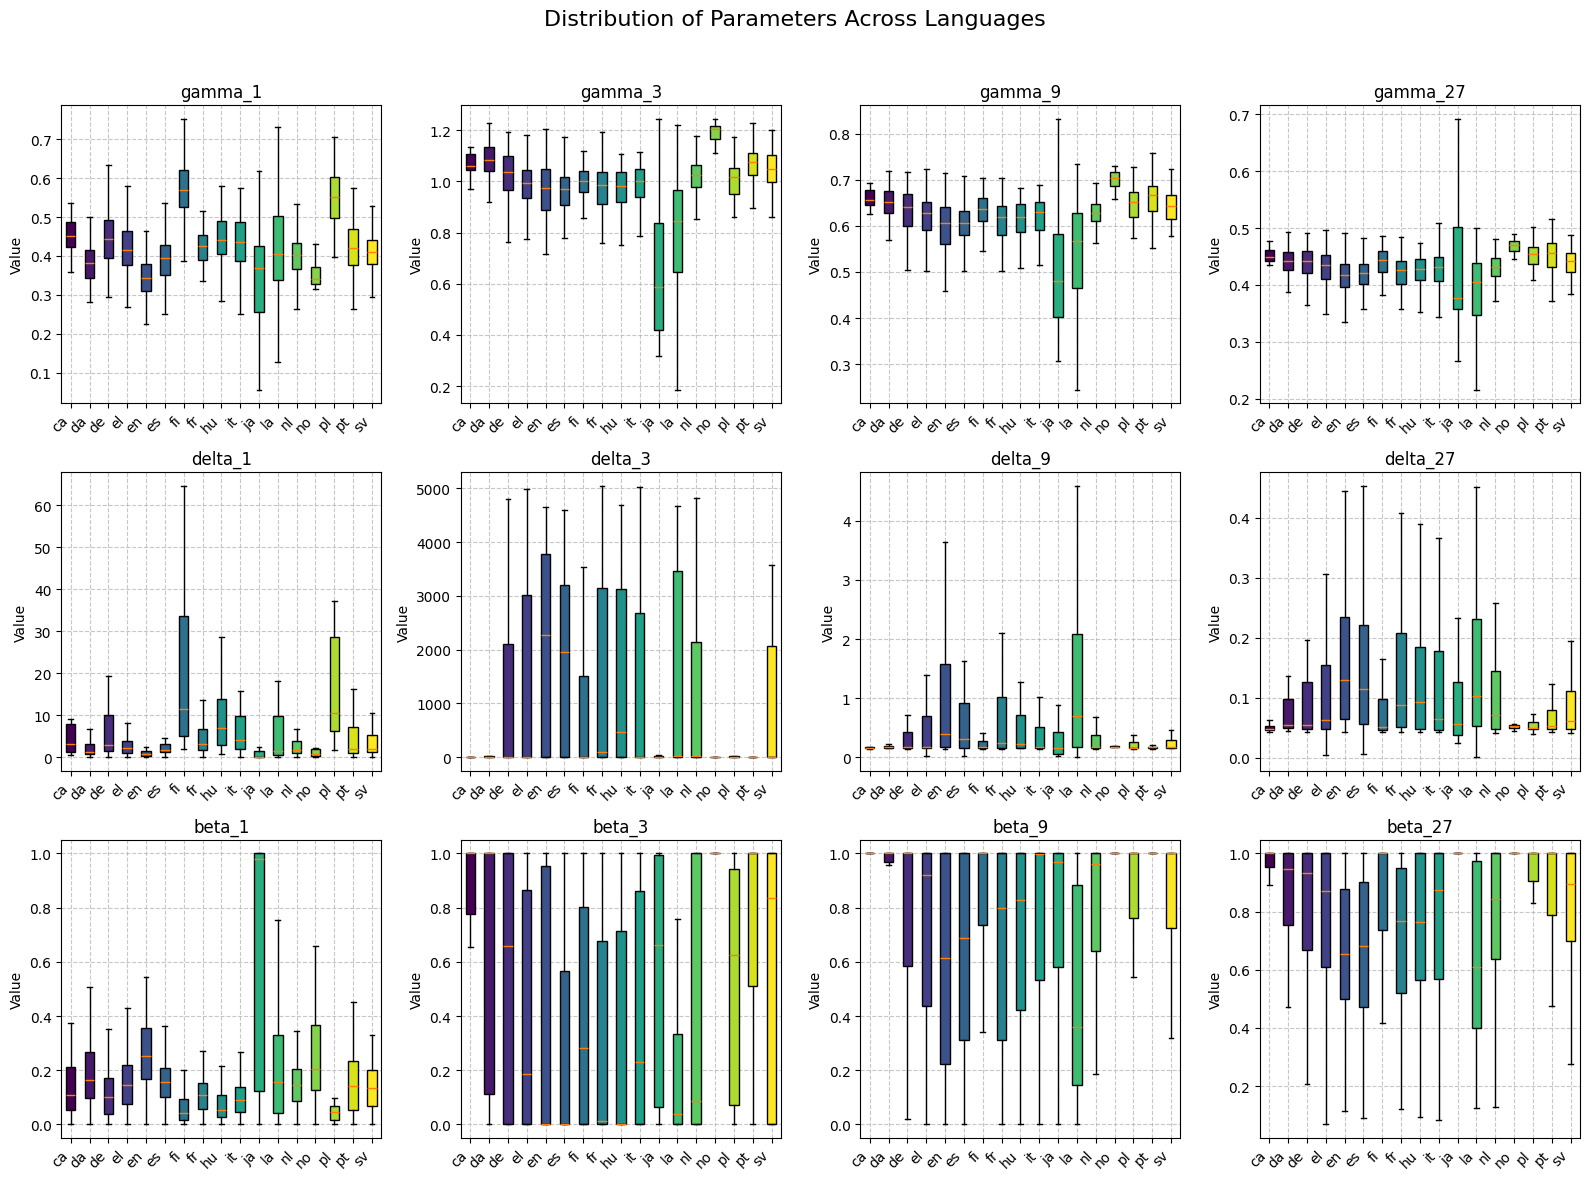

In [5]:
# Create a visualization to compare parameters across languages
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Distribution of Parameters Across Languages', fontsize=16)

# Set up the parameters to plot
params = [
    ["gamma_1", "gamma_3", "gamma_9", "gamma_27"],
    ["delta_1", "delta_3", "delta_9", "delta_27"],
    ["beta_1", "beta_3", "beta_9", "beta_27"]
]

# Create a boxplot for each parameter
for i, param_row in enumerate(params):
    for j, param in enumerate(param_row):
        ax = axes[i, j]
        
        # Create a temporary dataframe with just what we need
        plot_data = []
        languages = []
        
        for lang in spgc_metadata_sampled['language'].unique():
            data = spgc_metadata_sampled.loc[spgc_metadata_sampled['language'] == lang, param].dropna()
            if len(data) > 0:
                plot_data.append(data)
                # Clean up language code for display
                lang_code = lang.strip("[]'")
                languages.append(lang_code)
        
        # Create the boxplot
        bp = ax.boxplot(plot_data, patch_artist=True, showfliers=False)
        
        # Set colors for each boxplot
        colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        # Set plot title and labels
        ax.set_title(param)
        ax.set_xticklabels(languages, rotation=45, ha='right')
        ax.set_ylabel('Value')
        
        # Add grid for better readability
        ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Analysis of variance

In [9]:
# Create a dataframe to store the Kruskal-Wallis test results
kw_results = pd.DataFrame(
    index=['gamma', 'delta', 'beta'],
    columns=['1', '3', '9', '27']
)

# Define parameter groups
param_groups = {
    'gamma': ['gamma_1', 'gamma_3', 'gamma_9', 'gamma_27'],
    'delta': ['delta_1', 'delta_3', 'delta_9', 'delta_27'],
    'beta': ['beta_1', 'beta_3', 'beta_9', 'beta_27']
}

# Perform Kruskal-Wallis test for each parameter
for group_name, group_params in param_groups.items():
    for param in group_params:
        pool_order = param.split('_')[1]  # Extract pool order (1, 3, 9, 27)
        
        # Create a list of data for each language
        groups = []
        group_labels = []
        
        for lang in spgc_metadata_sampled['language'].unique():
            data = spgc_metadata_sampled.loc[spgc_metadata_sampled['language'] == lang, param].dropna()
            if len(data) > 0:
                groups.append(data)
                group_labels.append(lang)
        
        # Perform Kruskal-Wallis test
        if len(groups) > 1:  # Need at least 2 groups for the test
            stat, p_value = sps.kruskal(*groups)
            kw_results.loc[group_name, pool_order] = p_value
        else:
            kw_results.loc[group_name, pool_order] = float('nan')

# Format p-values with scientific notation for small values
kw_results_formatted = kw_results.applymap(lambda x: f"{x:.2e}" if pd.notnull(x) else "NaN")

# Display the results
kw_results_formatted

C:\Users\Pawel\AppData\Local\Temp\ipykernel_8208\1426312306.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  kw_results_formatted = kw_results.applymap(lambda x: f"{x:.2e}" if pd.notnull(x) else "NaN")


,1,3,9,27
gamma,7.93e-78,3.66e-60,2.09e-46,2.89e-34
delta,2.67e-37,6.26e-19,5.61e-15,4.16e-15
beta,8.63e-29,3.43e-29,1.74e-30,1.18e-31


In [16]:
# Perform post-hoc Dunn test with Bonferroni correction for each parameter
# We'll create a function to run the test and visualize the results

def perform_dunn_test_and_visualize(parameter_groups, spgc_metadata_sampled):
    """
    Perform Dunn's post-hoc test with Bonferroni correction for each parameter group
    and visualize the results using heatmaps.
    
    Args:
        parameter_groups: Dictionary of parameter groups to analyze
        spgc_metadata_sampled: DataFrame containing the data
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle('Dunn Test Results (p-values with Bonferroni correction)', fontsize=18)
    
    # Define symbols for parameter groups for better visualization
    param_symbols = {
        'gamma': '$\gamma$',
        'delta': '$\delta$',
        'beta': '$\\beta$'
    }
    
    # Loop through parameter groups
    for row, (group_name, params) in enumerate(parameter_groups.items()):
        param_symbol = param_symbols.get(group_name, group_name)
        
        for col, param in enumerate(params):
            ax = axes[row, col]
            
            # Extract language and data for Dunn test
            groups = []
            lang_codes = []
            
            for lang in spgc_metadata_sampled['language'].unique():
                data = spgc_metadata_sampled.loc[spgc_metadata_sampled['language'] == lang, param].dropna()
                if len(data) > 0:
                    groups.append(data.values)
                    lang_code = lang.strip("[]'")
                    lang_codes.append(lang_code)
            
            # Perform Dunn test
            if len(groups) > 2:  # Need at least 3 groups for post-hoc
                try:
                    # Perform Dunn test with Bonferroni correction
                    posthoc_results = sp.posthoc_dunn(groups, p_adjust='bonferroni')
                    
                    # Create a heatmap for the p-values
                    sns.heatmap(posthoc_results, annot=True, cmap='coolwarm_r', 
                               vmin=0, vmax=0.05, ax=ax, xticklabels=lang_codes, 
                               yticklabels=lang_codes, cbar=False, fmt='.3f')
                    
                    # Color p-values < 0.05 differently for emphasis
                    for i in range(posthoc_results.shape[0]):
                        for j in range(posthoc_results.shape[1]):
                            if posthoc_results.iloc[i, j] < 0.05:
                                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1.5))
                    
                    # Set plot title and labels
                    ax.set_title(f"{param_symbol}_{param.split('_')[1]}")
                except Exception as e:
                    ax.text(0.5, 0.5, f"Error: {str(e)}", horizontalalignment='center',
                           verticalalignment='center', transform=ax.transAxes)
            else:
                ax.text(0.5, 0.5, "Insufficient data for\npost-hoc test", horizontalalignment='center',
                       verticalalignment='center', transform=ax.transAxes)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Run the post-hoc tests and visualize
# perform_dunn_test_and_visualize(param_groups, spgc_metadata_sampled)

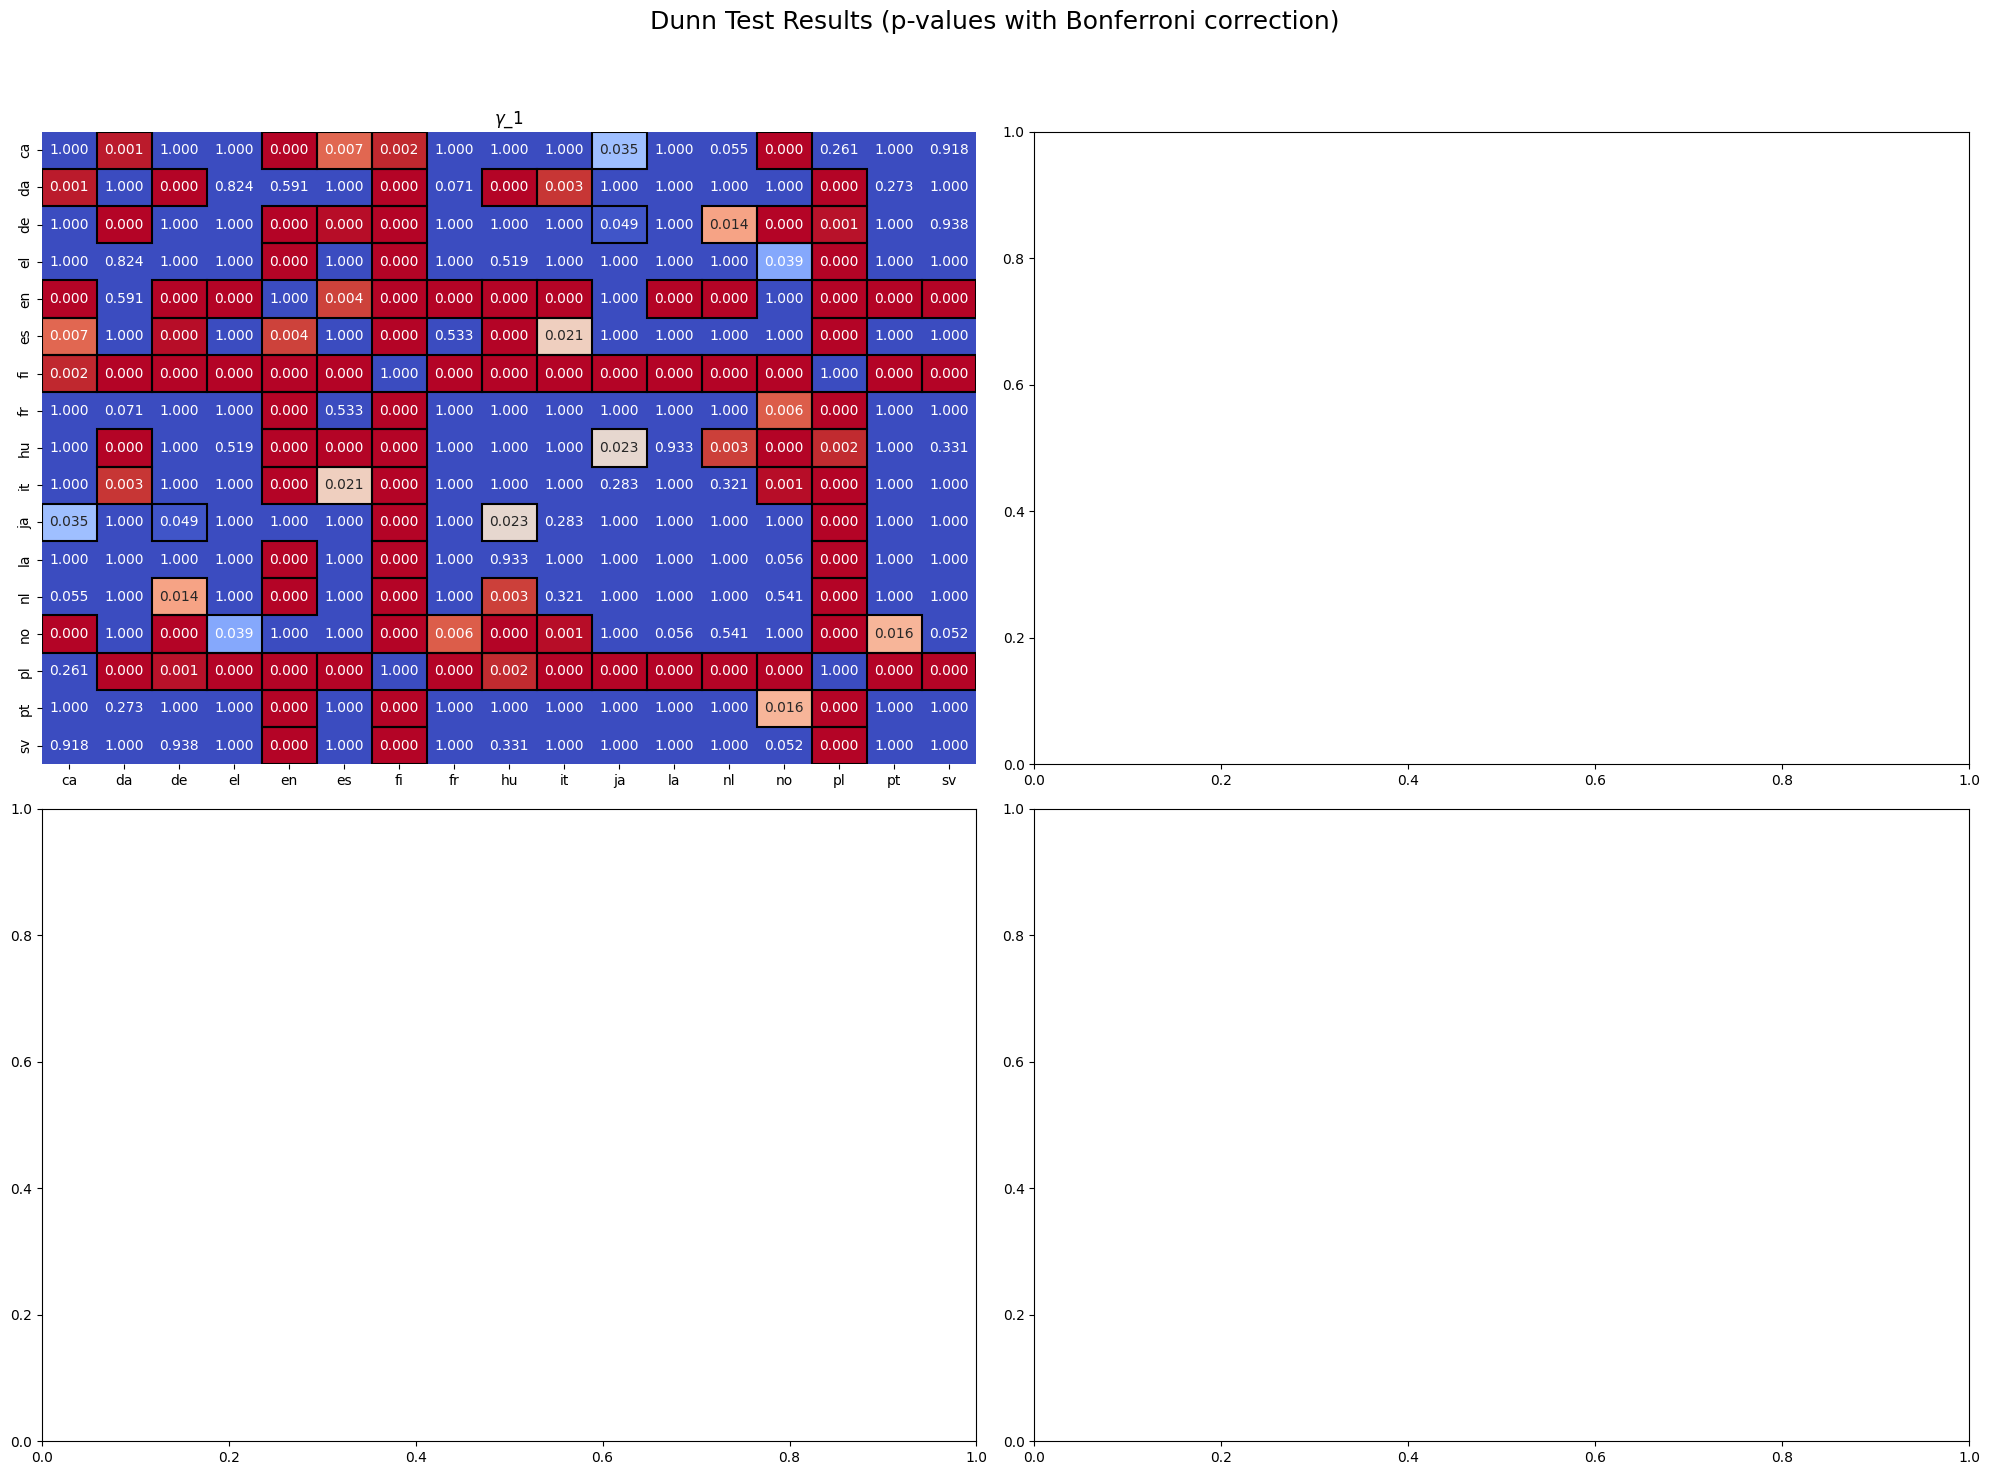

In [17]:
param_groups = {
    'gamma': ['gamma_1'],
}
perform_dunn_test_and_visualize(param_groups, spgc_metadata_sampled)
